# New Section

2481it [00:17, 143.35it/s]


(2481, 150, 150, 3)
80134624/80134624 [==============================] - 1s 0us/step
Model: "VGG19_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 20,159,298
Trainable params: 133,378
Non-trainable params: 20,

<ipython-input-2-70706fcb13ee>:127: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.5761 
Epoch 1: val_loss improved from inf to 0.67024, saving model to VGG19_Model.hdf5
34/34 [==============================] - 796s 23s/step - loss: 0.9010 - accuracy: 0.5761 - val_loss: 0.6702 - val_accuracy: 0.5542 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.6084 
Epoch 2: val_loss improved from 0.67024 to 0.65627, saving model to VGG19_Model.hdf5
34/34 [==============================] - 714s 21s/step - loss: 0.8157 - accuracy: 0.6084 - val_loss: 0.6563 - val_accuracy: 0.5622 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.6402 
Epoch 3: val_loss improved from 0.65627 to 0.64355, saving model to VGG19_Model.hdf5
34/34 [==============================] - 714s 21s/step - loss: 0.7536 - accuracy: 0.6402 - val_loss: 0.6435 - val_accuracy: 0.5863 - lr: 2.0000e-04
Epoch 4/30
34/34 [==

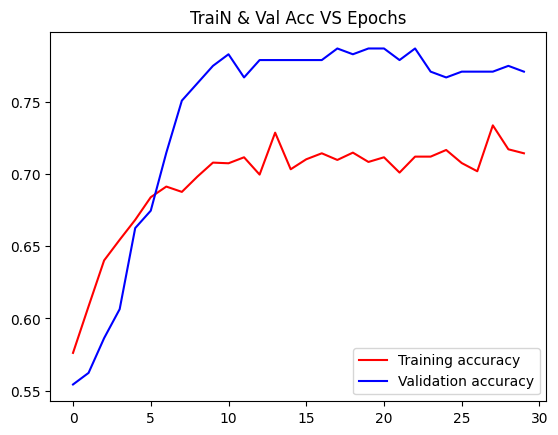

<Figure size 640x480 with 0 Axes>

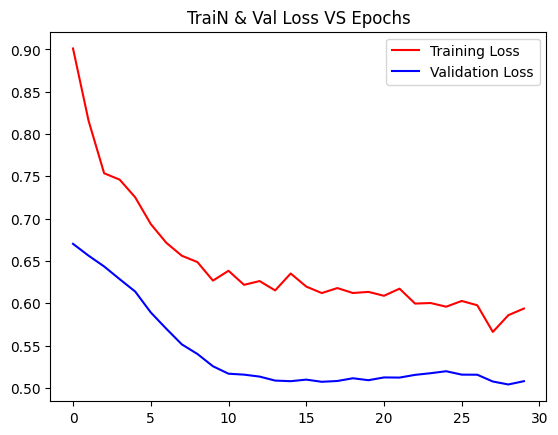

<Figure size 640x480 with 0 Axes>

8/8 [==============================] - 68s 8s/step - loss: 0.5041 - accuracy: 0.7751
Test Loss: 0.5040991306304932
8/8 [==============================] - 68s 8s/step
Test accuracy: 77.51004099845886
Confusion Score = [[ 90  44]
 [ 12 103]]
Precision = 0.7006802721088435
Recall = 0.8956521739130435
F1 Score = 0.7862595419847328


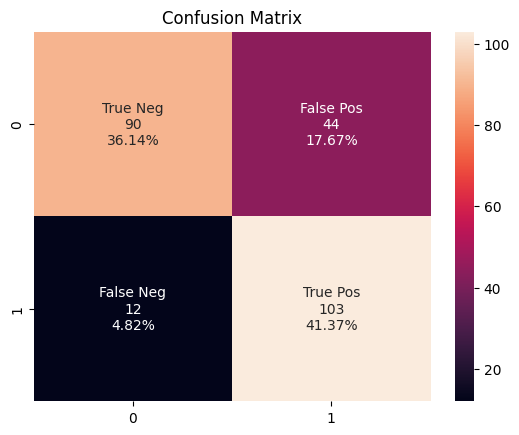

In [2]:
#Import Necessary Libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import VGG19
#from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
#import keras_preprocessing
!pip install Keras-Preprocessing
from keras_preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

#Split Into Train Data & Test Data

disease_types=['COVID', 'non-COVID']
data_dir = '/home'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

IMAGE_SIZE = 150
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)


Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)


vgg19_model = VGG19(weights = 'imagenet', include_top = False,input_shape=(150,150,3))
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'softmax')(x)
model = Model(vgg19_model.input,predictions)
for layer in vgg19_model.layers:
    layer.trainable = False
optimizer = Adam(lr=0.0002)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model._name = "VGG19_Architecture"
model.summary()

#Train the Model

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)

BATCH_SIZE = 64
EPOCHS = 30
SIZE=64
N_ch=3

training_datagen = ImageDataGenerator(rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        shear_range=0.2)

train_generator = training_datagen.flow(
	X_train, Y_train,
batch_size=64
)
training_datagen.fit(X_train)

filepath="VGG19_Model.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min',verbose=1)
callbacks_list = [checkpoint]

#history = model.fit_generator(train_generator, steps_per_epoch=32, epochs=10,
#                              validation_data=(X_val, Y_val),validation_steps=50,callbacks=callbacks_list)
datagen = ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)

datagen.fit(X_train)

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

#Plot the Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

model.load_weights("VGG19_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])


Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")


cfmatrix = confusion_matrix(Y_valx, Y_predx)
precision = precision_score(Y_valx, Y_predx)
recall = recall_score(Y_valx, Y_predx)
f1score = f1_score(Y_valx, Y_predx)

print('Test accuracy:', score[1]*100)
print(f"Confusion Score = {cfmatrix}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')